# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import plotly.graph_objects as go
import glob
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
# user written modules
import dataproject
from pandas_datareader import wb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

Import your data, either through an API or manually, and load it. 

In [70]:
data = pd.read_csv('Population estimates 2002-2019.csv')

In [71]:
data.head()

,Age,Sex,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0,Males,268276,275022,278646,286668,284192,286772,288756,293072,289377,284926,276371,274396,263091,257024,248474,241228,234151,221685
1,0,Females,254731,260634,263677,271832,266935,270112,271944,277719,272945,268292,260976,259651,249049,242916,234503,228728,220915,209322
2,0,Total,523007,535656,542323,558500,551127,556884,560700,570791,562322,553218,537347,534047,512140,499940,482977,469956,455066,431007
3,1,Males,271976,270053,276225,280318,287042,285122,288524,289814,292642,288996,284199,277263,274308,262728,256954,248341,241422,234386
4,1,Females,257257,256524,261795,265278,272025,267748,271504,273207,277321,272698,267521,261900,259608,248720,242753,234634,228990,221360


In [72]:
col_dict = {}
for i in range(2002, 2019+1): # range goes from 2008 to but not including 2018
    col_dict[str(i)] = f'pop{i}'

col_dict = {str(i) : f'pop{i}' for i in range(2002, 2019+1)}

data.rename(columns = col_dict, inplace=True)
data.head(10)

,Age,Sex,pop2002,pop2003,pop2004,pop2005,pop2006,pop2007,pop2008,pop2009,pop2010,pop2011,pop2012,pop2013,pop2014,pop2015,pop2016,pop2017,pop2018,pop2019
0,0,Males,268276,275022,278646,286668,284192,286772,288756,293072,289377,284926,276371,274396,263091,257024,248474,241228,234151,221685
1,0,Females,254731,260634,263677,271832,266935,270112,271944,277719,272945,268292,260976,259651,249049,242916,234503,228728,220915,209322
2,0,Total,523007,535656,542323,558500,551127,556884,560700,570791,562322,553218,537347,534047,512140,499940,482977,469956,455066,431007
3,1,Males,271976,270053,276225,280318,287042,285122,288524,289814,292642,288996,284199,277263,274308,262728,256954,248341,241422,234386
4,1,Females,257257,256524,261795,265278,272025,267748,271504,273207,277321,272698,267521,261900,259608,248720,242753,234634,228990,221360
5,1,Total,529233,526577,538020,545596,559067,552870,560028,563021,569963,561694,551720,539163,533916,511448,499707,482975,470412,455746
6,2,Males,270620,273992,272492,277714,281879,287756,286884,289944,290510,292330,288638,285627,277877,273801,262071,256565,248127,241671
7,2,Females,257511,259134,258551,263146,266608,272591,269262,272696,273807,276734,272305,268849,262572,259094,248046,242535,234683,229142
8,2,Total,528131,533126,531043,540860,548487,560347,556146,562640,564317,569064,560943,554476,540449,532895,510117,499100,482810,470813
9,3,Males,266706,272154,276432,274944,279355,283181,289244,288619,290910,291096,291941,289965,286447,277707,273332,261241,256349,248155


In [73]:
pop_italy = pd.wide_to_long(data, stubnames='pop', i=['Age','Sex'], j='year')
pop_italy = pop_italy.reset_index()
pop_italy.head(10)



,Age,Sex,year,pop
0,0,Males,2002,268276
1,0,Males,2003,275022
2,0,Males,2004,278646
3,0,Males,2005,286668
4,0,Males,2006,284192
5,0,Males,2007,286772
6,0,Males,2008,288756
7,0,Males,2009,293072
8,0,Males,2010,289377
9,0,Males,2011,284926


In [74]:


#as we can see the column age is not in the right format. We need to change it to int but we have to deal with the '100 e oltre' and 'Total' observations 
pop_italy.info()

#we can drop the observation relative to the total of the population 
pop_italy = pop_italy[pop_italy['Age'] != 'Total']

#Since 100 or more will be included in the same group of 100. we replace the '100 e oltre' with 100
pop_italy['Age'] = pop_italy['Age'].replace('100 and over', '100')

#Now we can change the column to int
pop_italy['Age'] = pop_italy['Age'].astype(int)

pop_italy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5508 entries, 0 to 5507
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Age     5508 non-null   object
 1   Sex     5508 non-null   object
 2   year    5508 non-null   int64 
 3   pop     5508 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 172.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 5454 entries, 0 to 5453
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Age     5454 non-null   int64 
 1   Sex     5454 non-null   object
 2   year    5454 non-null   int64 
 3   pop     5454 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 213.0+ KB


In [75]:
pop_italy = pop_italy[pop_italy['Sex'] != 'Total']
# Pivot the DataFrame
pop_italy_wide = pop_italy.pivot(index=['year','Age'], columns='Sex', values='pop')

pop_italy_wide.sort_values(['year','Age'], inplace=True)

pop_italy_wide.reset_index(inplace=True)

pop_italy_wide.columns.name = None
pop_italy_wide.head(10)



,year,Age,Females,Males
0,2002,0,254731,268276
1,2002,1,257257,271976
2,2002,2,257511,270620
3,2002,3,252084,266706
4,2002,4,251128,264829
5,2002,5,253760,268123
6,2002,6,253689,268085
7,2002,7,255399,269530
8,2002,8,262711,276926
9,2002,9,274159,288501


In [76]:
#as we can see the column age is not in the right format. We need to change it to int but we have to deal with the '100 e oltre' and 'Total' observations 
pop_italy.info()

#we can drop the observation relative to the total of the population 
pop_italy = pop_italy[pop_italy['Age'] != 'Total']

#Since 100 or more will be included in the same group of 100. we replace the '100 e oltre' with 100
pop_italy['Age'] = pop_italy['Age'].replace('100 and over', '100')

#Now we can change the column to int
pop_italy['Age'] = pop_italy['Age'].astype(int)


<class 'pandas.core.frame.DataFrame'>
Index: 3636 entries, 0 to 5435
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Age     3636 non-null   int64 
 1   Sex     3636 non-null   object
 2   year    3636 non-null   int64 
 3   pop     3636 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 142.0+ KB


In [77]:
# Create a new column with the age group of each observation
pop_italy['age_group'] = ''

for i in range(0, 101, 5):
    if i == 100:
        pop_italy.loc[pop_italy['Age'].between(i, i+5), 'age_group'] = '100-100+'
    else:
        pop_italy.loc[pop_italy['Age'].between(i, i+4), 'age_group'] = f'{i}-{i+4}'

# Summing up all the observations for each age group
pop_italy_agg = pop_italy.groupby(['age_group', 'year'])[['Totale maschi', 'Totale femmine', 'Totale']].sum()

# Resetting index
pop_italy_agg.reset_index(inplace=True)

# Splitting age_group into lower_bound and upper_bound in order to sort the age groups correctly
pop_italy_agg[['lower_bound', 'upper_bound']] = pop_italy_agg['age_group'].str.split('-', expand=True)

# Sorting the age groups
pop_italy_agg['lower_bound'] = pop_italy_agg['lower_bound'].astype(int)
pop_italy_agg.sort_values(['year','lower_bound'], inplace=True)
pop_italy_agg.reset_index(inplace=True)
pop_italy_agg.drop(['index', 'lower_bound', 'upper_bound'], axis=1, inplace=True)



KeyError: "Columns not found: 'Totale femmine', 'Totale maschi', 'Totale'"

In [51]:
fig = go.Figure()

# Adding male population data as positive values
fig.add_trace(go.Bar(
    y=pop_italy_agg['age_group'],
    x=pop_italy_agg['Totale maschi'],
    name='Male',
    orientation='h'
))

# Adding female population data as negative values to plot in opposite direction
fig.add_trace(go.Bar(
    y=pop_italy_agg['age_group'],
    x=pop_italy_agg['Totale femmine'] * -1,  # Multiplying by -1 to plot in opposite direction
    name='Female',
    orientation='h'
))

fig.update_layout(
    template='plotly_white', 
    title='Population in Italy',
    title_font_size=24,
    barmode='relative',
    bargap=0.1,  # Adjust as needed
    bargroupgap=0.2,  # Adjust as needed
    xaxis_title='Population',
    xaxis=dict(
        tickvals=[-2000000, -1000000, 0, 1000000, 2000000],
        ticktext=['2M', '1M', '0', '1M', '2M']
    ),
    width=800,  
    height=600  
)



In [80]:


I = pop_italy_agg['year'] ==2023


fig = go.Figure()

# Adding male population data as positive values
fig.add_trace(go.Bar(
        y=pop_italy_agg.loc[I,'age_group'],
        x=pop_italy_agg.loc[I,'Totale maschi'],
        name='Male',
        orientation='h'
))

# Adding female population data as negative values to plot in opposite direction
fig.add_trace(go.Bar(
        y=pop_italy_agg.loc[I,'age_group'],
        x=pop_italy_agg.loc[I,'Totale femmine'] * -1,  # Multiplying by -1 to plot in opposite direction
        name='Female',
        orientation='h'
))

fig.update_layout(
        template='plotly_white', 
        title=f'Population in Italy {year}',
        title_font_size=24,
        barmode='relative',
        bargap=0.1,  # Adjust as needed
        bargroupgap=0.2,  # Adjust as needed
        xaxis_title='Population',
        xaxis=dict(
            tickvals=[-2000000, -1000000, 0, 1000000, 2000000],
            ticktext=['2M', '1M', '0', '1M', '2M']
    ),
        width=800,  
        height=600  
)
fig.show()




In [74]:
import plotly.graph_objects as go
import pandas as pd
import ipywidgets as widgets

# Assuming you have imported pop_italy_agg DataFrame

def plot_func(df, year):
    I = df['year'] == year

    fig = go.Figure()

    # Adding male population data as positive values
    fig.add_trace(go.Bar(
        y=df.loc[I, 'age_group'],
        x=df.loc[I, 'Totale maschi'],
        name='Male',
        orientation='h'
    ))

    # Adding female population data as negative values to plot in opposite direction
    fig.add_trace(go.Bar(
        y=df.loc[I, 'age_group'],
        x=df.loc[I, 'Totale femmine'] * -1,  # Multiplying by -1 to plot in opposite direction
        name='Female',
        orientation='h'
    ))

    fig.update_layout(
        template='plotly_white',
        title=f'Population in Italy {year}',
        title_font_size=24,
        barmode='relative',
        bargap=0.1,  # Adjust as needed
        bargroupgap=0.2,  # Adjust as needed
        xaxis_title='Population',
        xaxis=dict(
            tickvals=[-2000000, -1000000, 0, 1000000, 2000000],
            ticktext=['2M', '1M', '0', '1M', '2M']
        ),
        width=800,
        height=600
    )
    fig.show()

# Create an interactive widget with a slider to choose the year
widgets.interact(plot_func,
                 df=widgets.fixed(pop_italy_agg),
                 year=widgets.IntSlider(description='Year',
                                        min=pop_italy_agg['year'].min(),
                                        max=pop_italy_agg['year'].max(),
                                        step=1,
                                        value=pop_italy_agg['year'].min())
                )


interactive(children=(IntSlider(value=2023, description='Year', max=2024, min=2023), Output()), _dom_classes=(…

<function __main__.plot_func(df, year)>

In [60]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Assuming 'year' is a column in your DataFrame
years = sorted(pop_italy_agg['year'].unique())

# Create an empty figure
fig = go.Figure()

# Add traces for each year
for year in years:
    # Filter the DataFrame for each year
    df_year = pop_italy_agg[pop_italy_agg['year'] == year]

    # Adding male population data as positive values
    fig.add_trace(go.Bar(
        y=df_year['age_group'],
        x=df_year['Totale maschi'],
        name='Male',
        orientation='h',
        visible=False  # Make all traces invisible by default
    ))

    # Adding female population data as negative values to plot in opposite direction
    fig.add_trace(go.Bar(
        y=df_year['age_group'],
        x=df_year['Totale femmine'] * -1,  # Multiplying by -1 to plot in opposite direction
        name='Female',
        orientation='h',
        visible=False  # Make all traces invisible by default
    ))

# Make the traces for the first year visible
fig.data[0].visible = True
fig.data[1].visible = True

# Create a slider for each year
sliders = [dict(
    active=0,
    currentvalue={"prefix": "year: "},
    pad={"t": 50},
    steps=[]
)]

for i, year in enumerate(years):
    slider_step = {"args": [
        [i],
        {"frame": {"duration": 300, "redraw": False},
         "mode": "immediate",
         "transition": {"duration": 300}}
    ],
        "label": str(year),  # Convert the year to a string
        "method": "animate"}
    
    # Add this line to append each step to the steps list of your slider
    sliders[0]['steps'].append(slider_step)

    

fig.update_layout(
    sliders=sliders,
    template='plotly_white', 
    title='Population in Italy',
    title_font_size=24,
    barmode='relative',
    bargap=0.1,  # Adjust as needed
    bargroupgap=0.2,  # Adjust as needed
    xaxis_title='Population',
    xaxis=dict(
        tickvals=[-2000000, -1000000, 0, 1000000, 2000000],
        ticktext=['2M', '1M', '0', '1M', '2M']
    ),
    width=800,  
    height=600  
)

fig.show()

KeyError: 'year'

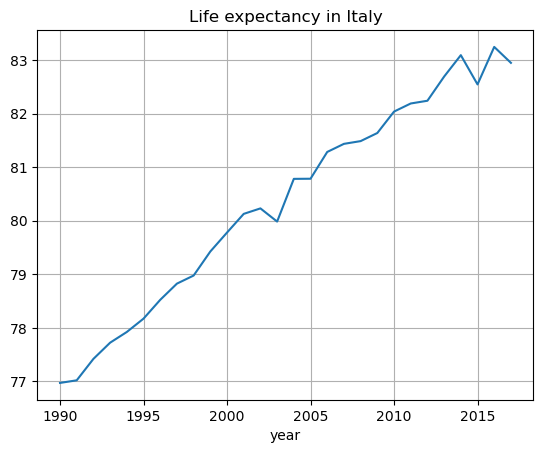

In [7]:
wb_fr = wb.download(indicator='SP.DYN.LE00.IN', country=['IT'], start=1990, end=2017)
wb_fr.reset_index(inplace=True)
wb_fr.rename(columns={'SP.DYN.LE00.IN': 'life_expectancy'}, inplace=True)
wb_fr['year'] = wb_fr['year'].astype(int)
wb_fr.head()

wb_birth = wb.download(indicator='SP.DYN.CBRT.IN', country=['IT'], start=1990, end=2017)




wb_fr.plot(x='year', y='life_expectancy', kind='line', title='Life expectancy in Italy', grid=True, legend=False)
wb_birth.plot(x='year', y='SP.DYN.CBRT.IN', kind='line', title='Birth rate in Italy', grid=True, legend=False)
plt.xlabel('Year')


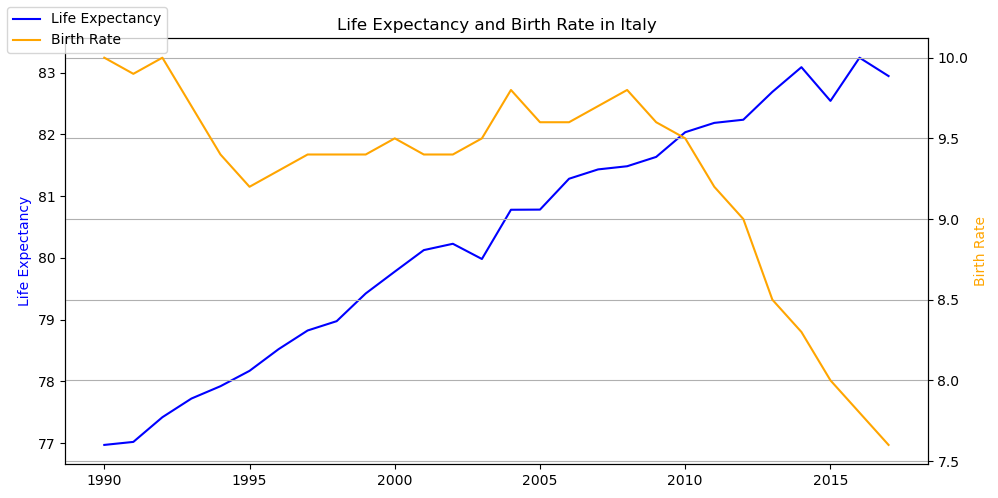

In [12]:

import matplotlib.pyplot as plt
import pandas as pd

# Downloading life expectancy data for Italy
wb_fr = wb.download(indicator='SP.DYN.LE00.IN', country=['IT'], start=1990, end=2017)
wb_fr.reset_index(inplace=True)
wb_fr.rename(columns={'SP.DYN.LE00.IN': 'life_expectancy'}, inplace=True)
wb_fr['year'] = wb_fr['year'].astype(int)

# Downloading birth rate data for Italy
wb_birth = wb.download(indicator='SP.DYN.CBRT.IN', country=['IT'], start=1990, end=2017)
wb_birth.reset_index(inplace=True)
wb_birth.rename(columns={'SP.DYN.CBRT.IN': 'birth_rate'}, inplace=True)
wb_birth['year'] = wb_birth['year'].astype(int)

# Merging dataframes on 'year'
merged_df = pd.merge(wb_fr, wb_birth, on='year')

# Creating a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting life expectancy on primary y-axis
ax1.plot(merged_df['year'], merged_df['life_expectancy'], color='blue', label='Life Expectancy')
ax1.set_ylabel('Life Expectancy', color='blue')

# Creating a secondary y-axis for birth rate
ax2 = ax1.twinx()
ax2.plot(merged_df['year'], merged_df['birth_rate'], color='orange', label='Birth Rate')
ax2.set_ylabel('Birth Rate', color='orange')

# Adding title and legend
plt.title('Life Expectancy and Birth Rate in Italy')
fig.tight_layout()
fig.legend(loc='upper left')
plt.xlabel('Year')

plt.grid(True)
plt.show()


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.